In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
import statsmodels.api as sm
import seaborn as sns
%matplotlib inline

file = pd.ExcelFile('C:\\Users\\sachin\\Desktop\\DataQuest\\My Projects\\Siddesh Assignment\\Analytical Interview DATASET.xlsx')
profile = pd.read_excel(file,'Customer Profile Data (DS#1)')
past_purchase = pd.read_excel(file,'Past Purchase Data (Ds#2)')
camp_coverage = pd.read_excel(file,'Campaign Coverage Data (DS#3)')
monthly_data = pd.read_excel(file,'Month Level Customer Data (DS#4')
socio_economic = pd.read_excel(file,'Socio Economic Data (DS#5)')

In [2]:
from collections import Counter

transact_dict = dict(Counter(monthly_data['Customer_ID']))

In [3]:
#Code is slow and needs to replaced by a faster alternative
#updates number of rows with same ID to transactions
for key,value in transact_dict.items():
    for id in monthly_data['Customer_ID']:
        if id==key:
            monthly_data['transactions'] = value
            
monthly_data = monthly_data.groupby('Customer_ID').mean()

In [4]:
master = (profile.join(past_purchase,on = 'Customer_ID', how='left',lsuffix='_left')
                 .join(camp_coverage,on='Customer_ID',how='left',lsuffix='_left')
                 .join(monthly_data,on='Customer_ID',how='left',lsuffix='_left')
                 .join(socio_economic,on='Customer_ID',how='left',lsuffix='_left'))

In [5]:
master['avg_sales'] = master['Revenue']/master['transactions']



In [6]:
master = master.drop({'Customer_ID','Customer_ID_left'}, axis=1)
master = master.dropna()

In [7]:
cat = [col for col in master.columns if master.dtypes[col] == 'object']
num = [col for col in master.columns if master.dtypes[col] != 'object']

In [8]:
master[cat] = master[cat].apply(lambda x: x.astype('category'),axis=0)
master['buy_decision_flag'] = master['buy_decision_flag'].astype('category')
master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3974 entries, 0 to 5144
Data columns (total 42 columns):
age                                 3974 non-null int64
job                                 3974 non-null category
marital_status                      3974 non-null category
education                           3974 non-null category
Previous_Default_Flag               3974 non-null category
House_Owned_Flag                    3974 non-null category
Loan_Availed_Flag                   3974 non-null category
Income_USD                          3974 non-null int64
Credit_rating                       3974 non-null category
Life_Stage_Code                     3974 non-null category
Ethnicity                           3974 non-null category
Employment                          3974 non-null category
Count_of_Transactions               3974 non-null int64
Loyalty_Tier                        3974 non-null category
Avg_Basket_Size                     3974 non-null float64
Reward_Points_Earn

In [9]:
y = master['buy_decision_flag']
x = master.loc[:, master.columns!= 'buy_decision_flag']

In [10]:
from scipy import stats
from scipy.stats import chi2_contingency
def crosstab(b):
    chi2_stat, p_val, dof, ex = stats.chi2_contingency(pd.crosstab(master.buy_decision_flag,master[b]))

    print('p_val of Chi sqare test for {} : {} '.format( b, p_val))

chi_new = [crosstab(cat[i]) for i in range(len(cat))]

p_val of Chi sqare test for job : 0.3715232221701297 
p_val of Chi sqare test for marital_status : 0.1475986935443773 
p_val of Chi sqare test for education : 0.9567460167747472 
p_val of Chi sqare test for Previous_Default_Flag : 0.22892983406098488 
p_val of Chi sqare test for House_Owned_Flag : 0.07733887027123489 
p_val of Chi sqare test for Loan_Availed_Flag : 0.15862692265908937 
p_val of Chi sqare test for Credit_rating : 0.8681164065839938 
p_val of Chi sqare test for Life_Stage_Code : 0.6821809228703191 
p_val of Chi sqare test for Ethnicity : 0.03540753274589701 
p_val of Chi sqare test for Employment : 0.4203885407109419 
p_val of Chi sqare test for Loyalty_Tier : 0.24686579082299845 
p_val of Chi sqare test for Mode_of_contact : 5.271215151240869e-26 
p_val of Chi sqare test for month_last_contacted_left : 9.595077392036167e-70 
p_val of Chi sqare test for day_of_week_last_contacted : 0.19484280782732458 
p_val of Chi sqare test for outcome_last_campaign : 2.237571642118438

In [11]:
del x['Previous_Default_Flag']
del x['House_Owned_Flag']
del x['Loan_Availed_Flag']
del x['Ethnicity']
del x['Loyalty_Tier']
del x['Mode_of_contact']
del x['month_last_contacted_left']
del x['day_of_week_last_contacted']
del x['outcome_last_campaign']
del x['Duration_of_last_contact_type']
del x['Num_of_contact_campaign_type']
del x['Num_contact_before_campaign_type']
del x['month_last_contacted']
del x['marital_status']

In [12]:
x = pd.get_dummies(x, drop_first=True)

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( x, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (3179, 48) (3179,)
Test set: (795, 48) (795,)


In [14]:
from sklearn.neighbors import KNeighborsClassifier
k = 6
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
neigh

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=6, p=2,
           weights='uniform')

In [15]:
yhat = neigh.predict(X_test)
yhat[0:5]

array(['no', 'no', 'no', 'no', 'no'], dtype=object)

In [16]:
from sklearn import metrics
print("Test set Accuracy: %.2f " %metrics.accuracy_score(y_test, yhat))

Test set Accuracy: 0.87 


## K Nearest Neighbour algorithm prodces results with 87% accuracy

In [18]:
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(x).transform(x)
X[0:5]

array([[ 4.31476707, -1.50068291, -1.3629094 ,  0.55518616,  0.04898778,
         0.44443037, -0.57746219,  0.20145937, -0.3458501 , -0.361363  ,
         0.01554513,  0.0716688 , -0.17048513, -0.042564  ,  0.        ,
         0.8364494 ,  0.60246928, -0.47831187,  0.76968704,  0.84271842,
         0.01554513, -0.48271391, -0.19109   , -0.16473857, -0.2699892 ,
         5.03168767, -0.1896707 , -0.33361286, -0.16793395, -0.45717083,
        -0.17871697, -0.22159068, -0.4003648 , -0.61205462, -0.02243936,
        -0.38800784, -0.69685542, -0.67899147, -0.50714602, -0.21907939,
         1.81554846, -0.02243936, -0.69406776, -0.83130249,  6.76409204,
         5.04909233, -0.27425618, -0.24842544],
       [ 1.03503949, -1.09326908, -1.40803163,  1.4581357 , -0.11730572,
         0.95908308, -0.57746219,  0.20145937, -0.3458501 ,  2.7673005 ,
        -0.74131595, -0.76436462, -0.66067752, -0.90393566,  0.        ,
        -0.11800597, -0.64293385, -0.32679588,  0.28386819,  0.39264742,
   

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (3179, 48) (3179,)
Test set: (795, 48) (795,)


In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [22]:
yhat = LR.predict(X_test)
yhat[:5]

array(['no', 'no', 'no', 'no', 'no'], dtype=object)

In [23]:
yhat_prob = LR.predict_proba(X_test)
yhat_prob

array([[0.92973925, 0.07026075],
       [0.93270198, 0.06729802],
       [0.89625956, 0.10374044],
       ...,
       [0.9214135 , 0.0785865 ],
       [0.93180127, 0.06819873],
       [0.92793757, 0.07206243]])

In [24]:
# Evaluation of model using Jaccard Index
from sklearn.metrics import jaccard_similarity_score
jaccard_similarity_score(y_test, yhat)


0.9987421383647799

In [26]:
#Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(y_test, yhat, labels=['yes','no']))

[[106   0]
 [  1 688]]


Confusion matrix, without normalization
[[106   0]
 [  1 688]]


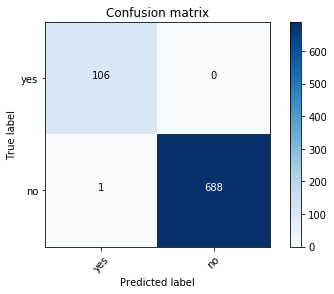

In [29]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=['yes','no'])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['yes','no'],normalize= False,  title='Confusion matrix')